# Latent Go-Explore for Maze

## Before you start

Before you start, make sure you have the gym-continuous-maze package installed. You can do this by running the following command:

```
pip install git+https://github.com/qgallouedec/gym-continuous-maze.git
```

## Instanciate and explore

First, instanciate LGE with the envrionement.

In [1]:
import gym_continuous_maze
from stable_baselines3 import SAC

from lge import LatentGoExplore

lge = LatentGoExplore(
    SAC,
    "ContinuousMaze-v0",
    module_type="inverse",
    latent_size=16,
    distance_threshold=1.0,
    lighten_dist_coef=1.0,
    p=0.05,
)

2024-12-27 13:52:32.902563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735303952.924960   22554 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735303952.932530   22554 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 13:52:32.957779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/ildefons/anaconda3/envs/lge39/lib/python3.9/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Then, make LGE explore for 30k timesteps.

In [2]:
num_timesteps = 30_000
lge.explore(num_timesteps)

/home/ildefons/ppprj/lge/lge/learners.py:76: UserWarning: Trying to train the module when buffer before the end of the first episode. Consider increasing learning_starts.
  warnings.warn(


## Plotting the results

First, we render the envrionement.

In [3]:
from IPython.display import display
from PIL import Image

In [4]:

env = lge.model.env

In [5]:
from IPython.display import display
from PIL import Image

env = lge.model.env
# img = env.render("rgb_array")
# img = Image.fromarray(img)
# display(img)

Now, we will compute the coverage. Fist, we need to get all the observations.

In [6]:
import numpy as np

observations = lge.replay_buffer.next_observations["observation"][:num_timesteps]

# `observations` has the shape (num_timesteps x num_envs x obs_shape) with num_env = 1.
# So we squeeze `observations` so that it has a shape of (num_timesteps x obs_shape).
observations = np.squeeze(observations)

Then, we compute an approximation of the space coverage by dividing the state space into bin of size 1 x 1.

In [7]:
bins = np.floor(observations)  # Divide the space into 1 x 1 bins.
unique, bin_uids = np.unique(bins, axis=0, return_inverse=True)  # Each bin has its own UID

explored_uid_so_far = []
coverage = np.zeros(num_timesteps)
for t in range(num_timesteps):
    bin_uid = bin_uids[t]
    if not bin_uid in explored_uid_so_far:
        explored_uid_so_far.append(bin_uid)
    coverage[t] = len(explored_uid_so_far) / (24 * 24)  # there are 24 x 24 reachable bins

Now, we can plot the coverage through timesteps.

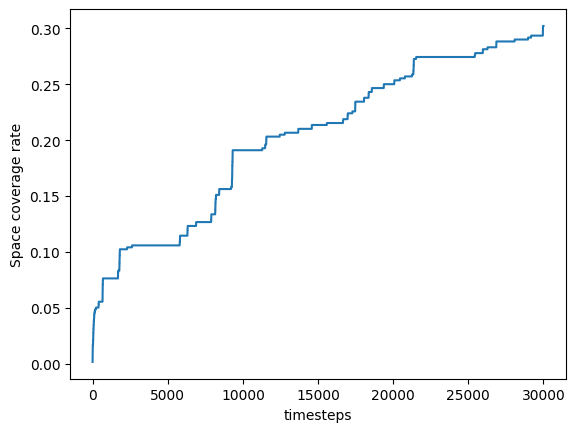

In [8]:
import matplotlib.pyplot as plt

plt.xlabel("timesteps")
plt.ylabel("Space coverage rate")
plt.plot(coverage)

Now we want to see what the latent space looks like. To do this, we will plot all the latent representations we encounter as scatter plots. The color of these points gives the probability that the corresponding observation is sampled as a goal.

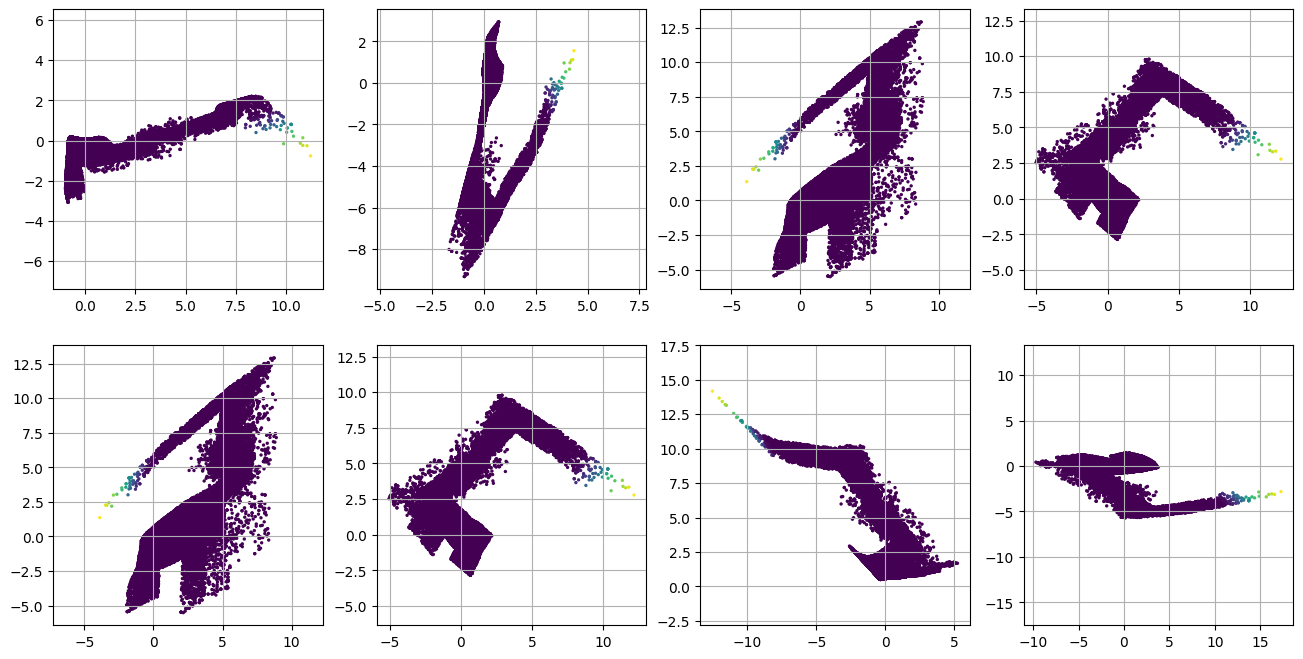

In [9]:
# Some borring lines to get the probability of each observation to be sampled as goal
lge.replay_buffer.recompute_embeddings()
embeddings = lge.replay_buffer.next_embeddings[:num_timesteps]
embeddings = np.squeeze(embeddings)
sorted_density = lge.replay_buffer.sorted_density[:num_timesteps]
_, index = np.unique(sorted_density, return_index=True)
p = lge.replay_buffer.p
prob = (1 - p) ** (np.arange(num_timesteps) - 1) * p
prob = prob[index]

# Get a color map to render this probability
cmap = plt.get_cmap()
color = cmap(prob / prob.max())

fig, axs = plt.subplots(2, 4)
fig.set_figheight(8)  # increase size, for readibility
fig.set_figwidth(16)

# Plot latent space
for row in range(2):
    for col in range(4):
        axs[row, col].grid()
        axs[row, col].axis("equal")
        latent_idx = 2 * (2 * row + col)
        axs[row, col].scatter(*embeddings[:, latent_idx : latent_idx + 2].T, c=color, s=2)